In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pickle', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pickle', 'rb') as file:
    y_scaler = pickle.load(file)

In [4]:
df = pd.read_csv("../bin/data_process.csv")

In [5]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['log_precio_contado', 'log_precio_nuevo'], axis=1)  
y = df['log_precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [6]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [7]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    y_pred_original = np.exp(y_pred_unscaled)
    y_test_original = np.exp(y_test_unscaled)
    
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

CPU times: total: 56 s
Wall time: 1min 23s


In [8]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,1.017848e+05,9.879629e+10,0.994027
2,gradient_boosting,1.954329e+05,2.007306e+11,0.987865
1,decision_tree,1.355644e+05,2.121429e+11,0.987175
5,linear_regressor,4.051304e+05,4.122849e+11,0.975076
4,kneighbors,3.709100e+05,1.022807e+12,0.938167
3,adaboost,7.431617e+05,1.331564e+12,0.919501
6,svr,2.473937e+06,1.027820e+13,0.378636


id_modelo: (0.6597649325652399) 
potencia_cv: (0.15026069844255668) 
antiguedad_coche: (0.10711010184827136) 
id_concesionario: (0.029103934400908294) 
log_kilometraje: (0.011162478567305876) 
peso: (0.007057861474304473) 
aceleracion: (0.006225472342029136) 
par: (0.005832847375407486) 
cilindrada: (0.004652271996466485) 
ano_matriculacion: (0.002866955589872668) 
num_marchas: (0.0027742125460399605) 
volumen: (0.0023275738412732025) 
garantia: (0.0018011456457516046) 
batalla: (0.0017166656204123782) 
velocidad_max: (0.0015398258388969912) 
capacidad_maletero: (0.0013649066971731523) 
deposito: (0.0010605787097094452) 
id_marca: (0.0008905098929570292) 
id_provincia: (0.0008338408692701966) 
tipo_cambio: (0.0004887409013079622) 
num_cilindros: (0.00044855532678975363) 
id_distintivo_ambiental_ECO: (0.00015790123032695852) 
num_puertas: (0.00013679316722203496) 
id_distintivo_ambiental_C: (0.00010493602779516946) 
combustible_Gasolina: (8.792982853858741e-05) 
id_traccion_total perman

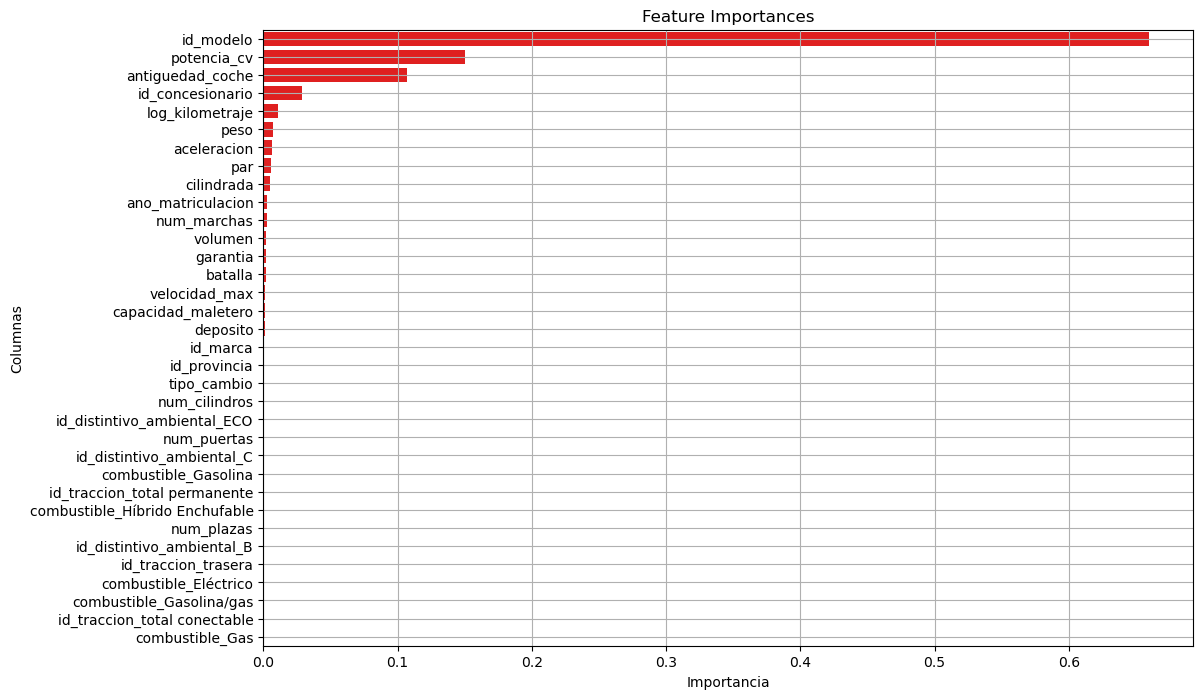

CPU times: total: 28.2 s
Wall time: 38.3 s


In [9]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [ ]:
%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
mejor_modelo = RandomForestRegressor(params)

mejor_modelo.fit(x, y)

In [ ]:
#model.fit(x, y)

#Crear una carpeta para guardar el objeto escalador

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(model, file)